In [16]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [17]:
import numpy as np
import pandas as pd

In [18]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [20]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [22]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [23]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
todays_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
twelve_months = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > twelve_months)
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation)
precipitation_df
# Sort the dataframe by date
precipitation_df.sort_values(by=["date"], ascending = False)

,date,prcp
2222,2017-08-23,0.45
1523,2017-08-23,0.08
1005,2017-08-23,0.00
359,2017-08-23,0.00
1522,2017-08-22,0.00
...,...,...
1188,2016-08-24,1.22
1875,2016-08-24,1.45
360,2016-08-24,2.15
1524,2016-08-24,2.15


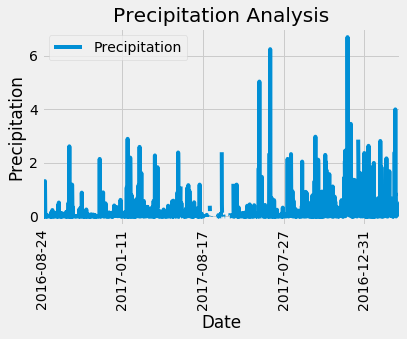

In [40]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Precipitation Analysis")
plt.legend(["Precipitation"])
plt.tight_layout()
plt.xticks(rotation=90)
plt.savefig("precipitation_analysis.png")
plt.show()

![precipitation](Images/precipitation.png)

In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [28]:
# Design a query to show how many stations are available in this dataset?
sessions = session.query(Measurement).group_by(Measurement.station).count()
sessions

9

In [29]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
              order_by(func.count(Measurement.tobs).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
best_station = most_active[0][0]
temperatures = session.query(Measurement.station, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == best_station).all()
temperatures

[('USC00519281', 54.0, 71.66378066378067, 85.0)]

In [31]:
# Choose the station with the highest number of temperature observations.
highest_number = session.query(Measurement.station, Measurement.tobs).\
                 filter(Measurement.station == 'USC00519281').\
                 filter(Measurement.date >= twelve_months).all()

highest_number_df = pd.DataFrame(highest_number)
highest_number_df

,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0
...,...,...
347,USC00519281,77.0
348,USC00519281,77.0
349,USC00519281,76.0
350,USC00519281,76.0


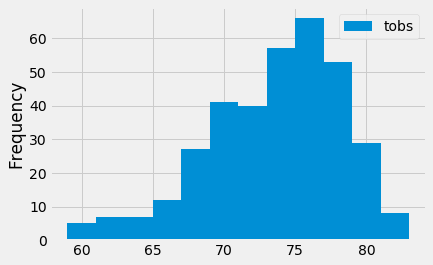

In [32]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_number_df.plot.hist('station',bins = 12)
plt.savefig("station_histo.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-06-01', '2017-06-01')
trip
trip_df = pd.DataFrame(trip, columns=['Minimum Temperature', 'Average Temperature', 'Maximum Temperature'])
trip_df

,Minimum Temperature,Average Temperature,Maximum Temperature
0,74.0,78.166667,81.0


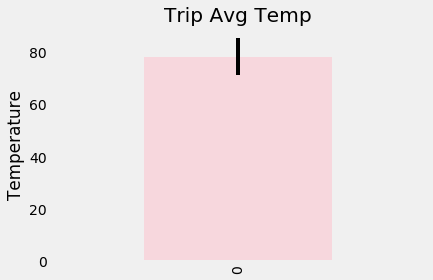

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
average_temp = trip_df['Average Temperature']
temp = trip_df['Maximum Temperature'] - trip_df['Minimum Temperature']
average_temp.plot.bar(yerr=temp,alpha=0.5, color='pink')
plt.title("Trip Avg Temp")
plt.ylabel("Temperature")
plt.grid()
plt.savefig()
plt.show()

## Optional Challenge Assignment

In [36]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [37]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [38]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [39]:
# Plot the daily normals as an area plot with `stacked=False`
